In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


In [12]:
!ls


data.csv.zip  sample_data


In [16]:
data = pd.read_csv('data.csv.zip', encoding='latin1')
data.head()
x = data["no2"].dropna().values

/tmp/ipython-input-4229426298.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv.zip', encoding='latin1')


In [18]:
r = 102317228

a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)
z = x + a * np.sin(b * x)



In [19]:
z = z.reshape(-1, 1)
z_tensor = torch.tensor(z, dtype=torch.float32)


In [20]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [23]:
gen = Gen()
dis = Dis()


In [24]:
loss_fn = nn.BCELoss()

gen_opt = optim.Adam(gen.parameters(), lr=0.001)
dis_opt = optim.Adam(dis.parameters(), lr=0.001)


In [25]:
epochs = 2000
batch_size = 64


In [26]:
for epoch in range(epochs):


    # Train Discriminator

    idx = np.random.randint(0, z_tensor.size(0), batch_size)
    real_data = z_tensor[idx]
    real_labels = torch.ones(batch_size, 1)

    noise = torch.randn(batch_size, 1)
    fake_data = gen(noise)
    fake_labels = torch.zeros(batch_size, 1)

    real_out = dis(real_data)
    fake_out = dis(fake_data.detach())

    dis_loss = loss_fn(real_out, real_labels) + loss_fn(fake_out, fake_labels)

    dis_opt.zero_grad()
    dis_loss.backward()
    dis_opt.step()


    # Train Generator

    noise = torch.randn(batch_size, 1)
    fake_data = gen(noise)
    fake_out = dis(fake_data)

    gen_loss = loss_fn(fake_out, real_labels)

    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    if epoch % 400 == 0:
        print("Epoch:", epoch,
              "Dis Loss:", dis_loss.item(),
              "Gen Loss:", gen_loss.item())


Epoch: 0 Dis Loss: 0.7535808086395264 Gen Loss: 0.692188024520874
Epoch: 400 Dis Loss: 0.3479177951812744 Gen Loss: 1.8137215375900269
Epoch: 800 Dis Loss: 1.0608574151992798 Gen Loss: 1.9314242601394653
Epoch: 1200 Dis Loss: 1.0018376111984253 Gen Loss: 1.4242498874664307
Epoch: 1600 Dis Loss: 1.2284616231918335 Gen Loss: 0.9751843810081482


In [27]:
noise = torch.randn(10000, 1)
fake_z = gen(noise).detach().numpy()


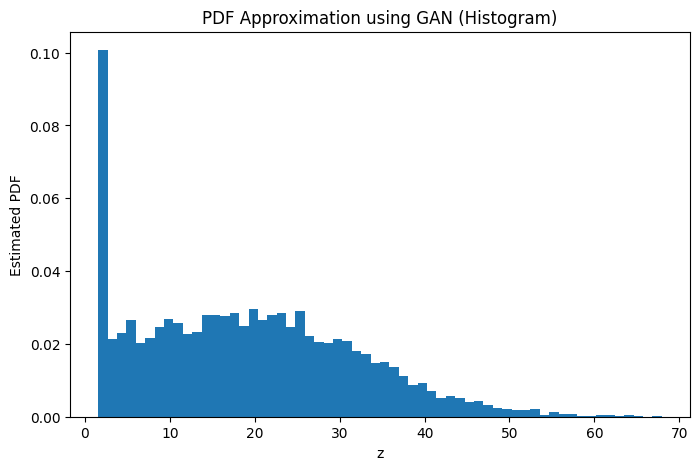

In [29]:

plt.figure(figsize=(8, 5))
plt.hist(fake_z, bins=60, density=True)
plt.xlabel("z")
plt.ylabel("Estimated PDF")
plt.title("PDF Approximation using GAN (Histogram)")
plt.show()


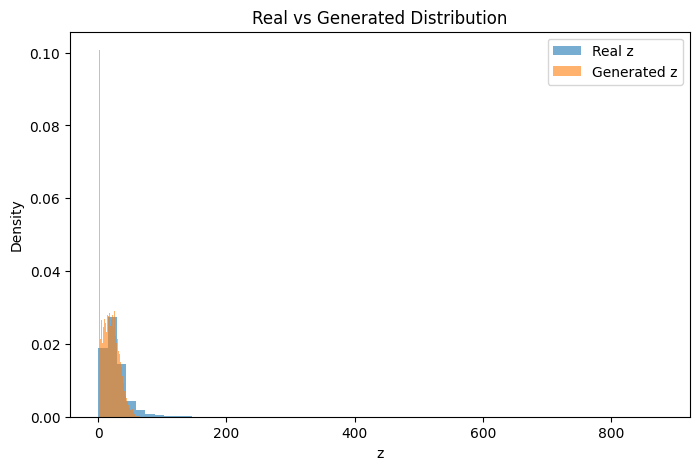

In [31]:
plt.figure(figsize=(8, 5))
plt.hist(z, bins=60, density=True, alpha=0.6, label="Real z")
plt.hist(fake_z, bins=60, density=True, alpha=0.6, label="Generated z")
plt.legend()
plt.xlabel("z")
plt.ylabel("Density")
plt.title("Real vs Generated Distribution")
plt.show()
